# Importação de bibliotecas

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define o caminho do diretório base e o tamanho que as imagens vão ter

In [2]:
img_width, img_height = 150, 150
# Diretório onde estão as imagens
train_data_dir = r'C:\Users\eluar\Documents\Estudo_IA_Python\Classificacao_Ronilson_projeto\Pequi'

# Função para carregar a base e dividir em conjunto de treino e teste e difinir as labels

In [3]:
def carregaBase(caminho, target_size, batch_size=32, split_ratio=0.7):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=(1 - split_ratio))

    # Gerador de dados de treinamento
    train_generator = datagen.flow_from_directory(
        caminho,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        subset='training')  # Conjunto de treinamento
    
    # Gerador de dados de validação
    validation_generator = datagen.flow_from_directory(
        caminho,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        subset='validation')  # Conjunto de validação
    
    return train_generator, validation_generator

# Carrega a base e mostra as labels 

In [4]:
base_train, base_test = carregaBase(train_data_dir, target_size=(img_height, img_width))

#Imprime conjunto e labels 
class_indices = base_train.class_indices
print(class_indices)

Found 700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
{'Doente': 0, 'Saudavel': 1}


# Função para avaliar os modelos

In [6]:
def plotMatrizConfMD(matriz, modelo):
    #Plotar o grafico da matriz de confusão
    plt.figure(figsize=(8, 5))
    plt.title(f'Matriz de Confusao {modelo}')
    df_cm = pd.DataFrame(matriz, index=["DOENTE","SAUDAVEL"], columns=["DOENTE","SAUDAVEL"])
    ax = sns.heatmap(df_cm, cmap='Oranges', annot = True, fmt = '' )
    for text in ax.texts:
        text.set_text(f"{float(text.get_text())}")

    plt.show()


def avaliaModelo(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    
    # Calculando a especificidade
    conf_matrix = confusion_matrix(y_true, y_pred)
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    
    print(f'Acurácia: {accuracy}')
    print(f'Precisão: {precision}')
    print(f'Sensibilidade (Recall): {recall}')
    print(f'Especificidade: {specificity}')
    
    plotMatrizConfMD(conf_matrix, "Inception")

# Define o número de classes/ saídas alvo

In [7]:
num_classes = 2

# Cria CNN InceptionNet

In [8]:
def inception_module(x, filters):
    f1, f2_in, f2_out, f3_in, f3_out, f4_out = filters

    conv1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

    conv3 = Conv2D(f2_in, (1, 1), padding='same', activation='relu')(x)
    conv3 = Conv2D(f2_out, (3, 3), padding='same', activation='relu')(conv3)

    conv5 = Conv2D(f3_in, (1, 1), padding='same', activation='relu')(x)
    conv5 = Conv2D(f3_out, (5, 5), padding='same', activation='relu')(conv5)

    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool = Conv2D(f4_out, (1, 1), padding='same', activation='relu')(pool)

    return concatenate([conv1, conv3, conv5, pool], axis=-1)



def criaInceptionSimplified(input_shape, num_classes, x_train):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='valid', activation='relu')(inputs)
    x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = Conv2D(80, (1, 1), padding='valid', activation='relu')(x)
    x = Conv2D(192, (3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Adicionando os módulos Inception
    x = inception_module(x, [64, 48, 64, 64, 96, 32])
    x = inception_module(x, [64, 48, 64, 64, 96, 64])
    
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    # Compilando o modelo
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    model.fit(x_train,
              epochs=100)
    
    return model

# Executa o modelo InceptionNet

In [9]:
input_shape = (img_height, img_width, 1) 
inceptionNet = criaInceptionSimplified(input_shape, num_classes, base_train)

Epoch 1/20
22/22 [==============================] - 29s 1s/step - loss: 0.7595 - accuracy: 0.4900
Epoch 2/20
22/22 [==============================] - 32s 1s/step - loss: 0.6950 - accuracy: 0.4929
Epoch 3/20
22/22 [==============================] - 31s 1s/step - loss: 0.6931 - accuracy: 0.5000
Epoch 4/20
22/22 [==============================] - 34s 2s/step - loss: 0.6918 - accuracy: 0.5014
Epoch 5/20
22/22 [==============================] - 30s 1s/step - loss: 0.6839 - accuracy: 0.5514
Epoch 6/20
22/22 [==============================] - 32s 1s/step - loss: 0.6623 - accuracy: 0.6057
Epoch 7/20
22/22 [==============================] - 29s 1s/step - loss: 0.6487 - accuracy: 0.5943
Epoch 8/20
22/22 [==============================] - 31s 1s/step - loss: 0.6408 - accuracy: 0.6300
Epoch 9/20
22/22 [==============================] - 28s 1s/step - loss: 0.5835 - accuracy: 0.6971
Epoch 10/20
22/22 [==============================] - 31s 1s/step - loss: 0.5576 - accuracy: 0.7171
Epoch 11/20
22/22 [

# Obtendo os valores das imgens e suas labels 

In [10]:
# Fazer previsões no conjunto de validação
x_test, y_test = zip(*(base_test[i] for i in range(len(base_test))))
x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)

# Realiza a Previsão

In [11]:
# Prever as classes das imagens de validação
y_pred = inceptionNet.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Avalia a Previsão 

Acurácia: 0.73
Precisão: 0.7402618505965922
Sensibilidade (Recall): 0.73
Especificidade: 0.8333333333333334


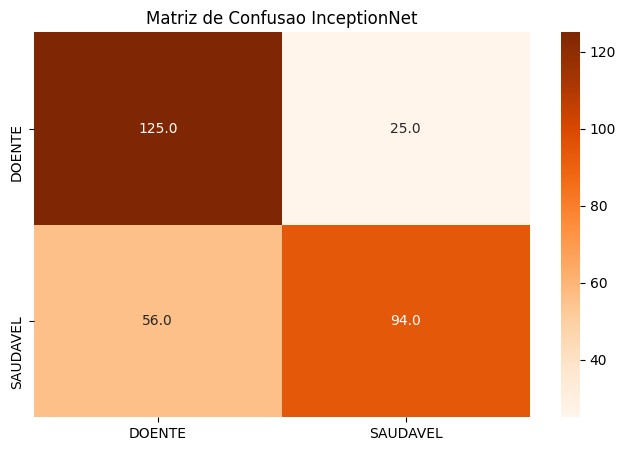

In [12]:
avaliaModelo(y_true_classes, y_pred_classes)